In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_docs.vis import embed
from keras.callbacks import CSVLogger

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio

from IPython import display
import glob
import PIL
import time
import os
import csv
import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir('/content/gdrive/MyDrive/5. M.Eng/cs6787/final project/cDCGAN')

In [ ]:
num_classes = 10
batch_size = 64
num_channels = 1
image_size = 28
latent_dim = 128
max_items_per_class = 4000 # for loading data
epochs = 20

opt = tf.keras.optimizers.Adam()

now = datetime.datetime.now().isoformat(timespec='seconds')
unique = 'adam_'+now

In [ ]:
#@title
def load_data(img_size, max_items_per_class):
  """
  Load all data from the data file.
  """
  all_files = glob.glob(os.path.join('data_chosen', '*.npy'))

  #initialize variables 
  x = np.empty([0, img_size**2])
  y = np.empty([0])
  class_names = []

  #load each data file 
  for idx, file in enumerate(all_files):
      data = np.load(file)
      data = data[0: max_items_per_class, :]
      labels = np.full(data.shape[0], idx)

      x = np.concatenate((x, data), axis=0)
      y = np.append(y, labels)

      class_name, ext = os.path.splitext(os.path.basename(file))
      class_names.append(class_name)

  data = None
  labels = None

  #randomize the dataset 
  permutation = np.random.permutation(y.shape[0])
  x = x[permutation, :]
  y = y[permutation]

  x = x.reshape(40000, img_size, img_size)

  # Scale the pixel values to [0, 1] range
  x = x.astype("float32") / 255.0
  # Add a channel dimension to the images
  #x = np.reshape(x, (-1, img_size, img_size, 1))

  print(f"Shape of training images: {x.shape}")
  print(f"Shape of training labels: {y.shape}")

  random_idx = np.random.choice(range(len(x)), round(len(x)*0.8), replace=False)
  mask=np.full(len(x), True, dtype=bool)
  mask[random_idx]=False
  train_images=x[mask]
  train_labels=y[mask]
  test_images=x[~mask]
  test_labels=y[~mask]

  return train_images, train_labels, test_images, test_labels

In [ ]:
images, labels, test_images, test_labels = load_data(image_size, max_items_per_class)

Shape of training images: (40000, 28, 28)
Shape of training labels: (40000,)


In [ ]:
class_names = ['airplane',
              'apple',
              'bus',
              'fish',
              'key',
              'nose',
              'snake',
              'purse',
              'star',
              'tree']

In [ ]:
def make_model():
    """
    Makes a convolutional neural network.
    """
    c = 32 # number of channels
    d = 128 # dense output
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(c, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPool2D((2, 2)))
    model.add(layers.Conv2D(c, (3, 3), activation='relu'))
    model.add(layers.MaxPool2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(d, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(10))
    return model

model = make_model()

In [ ]:
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Feed the model

To start training,  call the [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method—so called because it "fits" the model to the training data:

In [ ]:
history = model.fit(images, labels, epochs=epochs)
model.save('classification_'+unique+'.h5')

Epoch 1/20
250/250 [==============================] - 7s 26ms/step - loss: 0.9136 - accuracy: 0.7196
Epoch 2/20
250/250 [==============================] - 7s 26ms/step - loss: 0.5267 - accuracy: 0.8469
Epoch 3/20
250/250 [==============================] - 7s 27ms/step - loss: 0.4189 - accuracy: 0.8765
Epoch 4/20
250/250 [==============================] - 7s 28ms/step - loss: 0.3499 - accuracy: 0.8976
Epoch 5/20
250/250 [==============================] - 7s 27ms/step - loss: 0.2873 - accuracy: 0.9144
Epoch 6/20
250/250 [==============================] - 7s 27ms/step - loss: 0.2435 - accuracy: 0.9266
Epoch 7/20
250/250 [==============================] - 7s 27ms/step - loss: 0.2025 - accuracy: 0.9355
Epoch 8/20
250/250 [==============================] - 7s 27ms/step - loss: 0.1623 - accuracy: 0.9490
Epoch 9/20
250/250 [==============================] - 7s 27ms/step - loss: 0.1248 - accuracy: 0.9596
Epoch 10/20
250/250 [==============================] - 7s 27ms/step - loss: 0.0958 - accura

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.9894 (or 98.94%) on the training data.

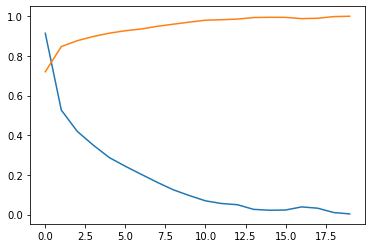

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

1000/1000 - 8s - loss: 0.7690 - accuracy: 0.8858 - 8s/epoch - 8ms/step

Test accuracy: 0.8858437538146973


88.05% accuracy

## Prediction

In [ ]:
class_model = keras.models.load_model('classification_20_2021-11-26T22:15:58.h5')

In [ ]:
def predict(model, images):
    probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
    predictions = probability_model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    return pred_classes

In [ ]:
random_idx = np.random.choice(range(len(test_images)), 10, replace=False)
mask=np.full(len(test_images), False, dtype=bool)
mask[random_idx]=True
select_imgs=test_images[mask]
select_labels=test_labels[mask]

In [ ]:
pred_classes = predict(class_model, select_imgs)

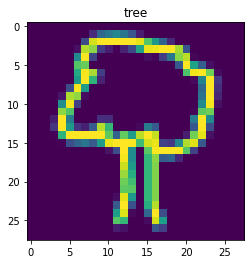

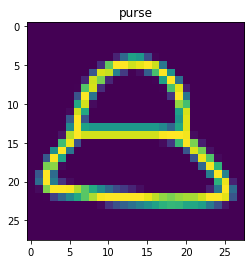

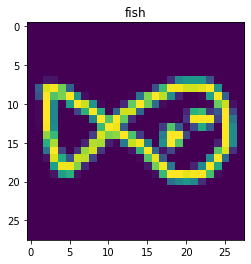

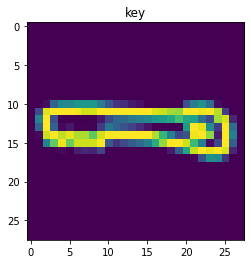

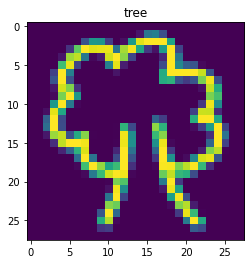

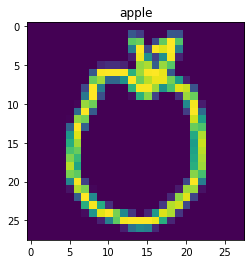

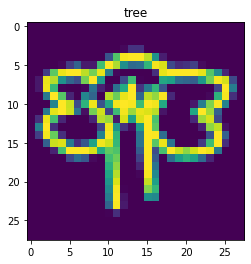

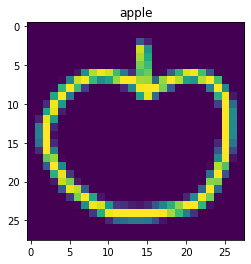

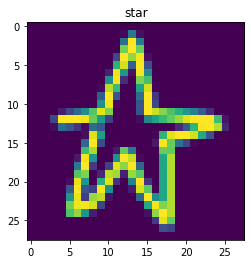

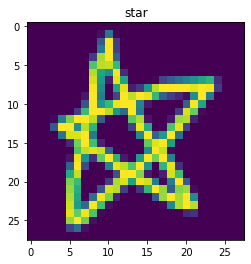

In [ ]:
for i in range(10):
  plt.title(class_names[pred_classes[i]])
  plt.imshow(select_imgs[i])
  plt.show()

In [ ]:
print('classification_'+unique+'.h5')

classification_adam_2021-12-02T22:17:35.h5


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
preds = model.predict(test_images)

In [ ]:
cm = confusion_matrix(test_labels, np.argmax(preds, axis=1))

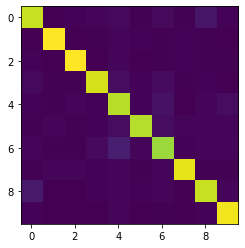

In [ ]:
plt.imshow(cm)